**Data mining Project - University of Pisa, acedemic year 2023/24**

**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Density clustering

Import library and dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics 
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
from plot_utils import plot_scattermap_plotly
from clustering_utils import plot_dbscan, plot_bars_by_cluster, compute_bss_per_cluster
from clustering_utils import plot_hists_by_cluster_dbscan, sankey_plot
from clustering_utils import plot_distance_matrices, compute_permutation_invariant_external_metrics

In [2]:
incidents_df = pd.read_csv(
    '../data/incidents_indicators.csv',
    index_col=0,
    parse_dates=['date', 'date_original'],
    date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d')
)

In [3]:
incidents_df.head(2)

date date_original    year  month  day  day_of_week         state  \
0 2015-05-02    2015-05-02  2015.0      5    2            5       INDIANA   
1 2017-04-03    2017-04-03  2017.0      4    3            0  PENNSYLVANIA   

                         address  latitude  longitude  ... n_unharmed_prop  \
0  Lafayette Road and Pike Plaza   39.8322   -86.2492  ...             0.0   
1                      5647 US 6   41.6645   -78.7856  ...             0.0   

  n_males_prop log_n_males_mean_ratio  surprisal_n_males  \
0          1.0              -0.284676           1.290677   
1          1.0              -0.230767           0.341037   

   surprisal_characteristics  n_arrested_prop log_n_participants_mean_ratio  \
0                   1.812630              0.0                     -0.485560   
1                   2.662965              0.0                     -0.384686   

   surprisal_n_participants n_participants surprisal_day  
0                  1.098032            1.0      5.513070  
1                  0.662965            1.0      3.247928  

[2 rows x 91 columns]

Prepare dataset and a list of indices and numerical attributes for choosen state: Illinois.

In [4]:
illinois_df = incidents_df[incidents_df['state']=='ILLINOIS']
illinois_df.head(2)

date date_original    year  month  day  day_of_week     state  \
19 2016-07-08    2016-07-08  2016.0      7    8            4  ILLINOIS   
21 2014-04-19    2014-04-19  2014.0      4   19            5  ILLINOIS   

                        address  latitude  longitude  ... n_unharmed_prop  \
19  500 block of North Lavergne   41.8895   -87.7507  ...             0.0   
21        1700 West 85th Street   41.7394   -87.6656  ...             0.0   

   n_males_prop log_n_males_mean_ratio  surprisal_n_males  \
19          1.0               0.724029           3.756729   
21          1.0              -0.302575           0.700440   

    surprisal_characteristics  n_arrested_prop log_n_participants_mean_ratio  \
19                   4.707819              0.0                      0.609658   
21                   0.942413              0.0                     -0.499119   

    surprisal_n_participants n_participants surprisal_day  
19                  3.366782            3.0      7.614710  
21                  0.776675            1.0      5.787903  

[2 rows x 91 columns]

In [5]:
ind_names_list = [
    # geographical
    'lat_proj', 'lon_proj', 'location_imp', 'surprisal_address_type',
    # age 
    'age_range', 'avg_age', 'surprisal_min_age',
    'n_child_prop', 'n_teen_prop', 'surprisal_age_groups', 
    # number of participants by group
    'severity', 'n_killed_prop', 'surprisal_n_killed', 'n_injured_prop',
    'surprisal_n_injured', 'n_unharmed_prop',
    # gender
    'n_males_prop', 'surprisal_n_males', 'n_arrested_prop',
    # characteristics
    'surprisal_characteristics', 
    # number of participantes
    'surprisal_n_participants', 'n_participants', 
    # date
    'surprisal_day']

## DBSCAN

In our clustering analysis, we chose to use DBSCAN (Density-Based Spatial Clustering of Applications with Noise) to perform density-based clustering. 
DBSCAN defines a cluster as a dense region of objects, offering a robust solution for identifying clusters with diverse shapes and sizes within complex datasets. This algorithm provides a flexible and effective approach to cluster analysis. 
Unlike traditional partitional clustering algorithms that necessitate pre-specification of the number of clusters, DBSCAN autonomously detects clusters during the analysis, alleviating the need for prior knowledge about the dataset.

DBSCAN excels in handling datasets with irregular clusters, arbitrary shapes, and varying sizes. It is particularly robust in the presence of noise or outliers, classifying points in low-density regions as noise. This adaptability allows DBSCAN to discover clusters that may be challenging for other clustering methods, such as K-means, to identify.

Pros:
- Accommodates irregular clusters with arbitrary shapes and sizes.
- Effective in the presence of noise or outliers.
- Identifies clusters that may go unnoticed by traditional clustering methods like K-means.

Cons:
- Faces challenges when clusters exhibit widely varying densities.
- Encounters difficulties with high-dimensional data due to the nuanced definition of density.

## Indices and numerical feauters correlation

Since DBSCAN encounters difficulties with high-dimensional data, we decided to address this challenge by plotting the correlation matrix of all possible attributes. The goal is to choose a subset of attributes that are not highly correlated with each other for the clustering analysis.

In our previous study, we thoroughly examined the features' correlation and distribution in the notebook containing the data understanding analysis state by state. Therefore, we are taking those observations into consideration to choose the subset of attributes for our clustering analysis.

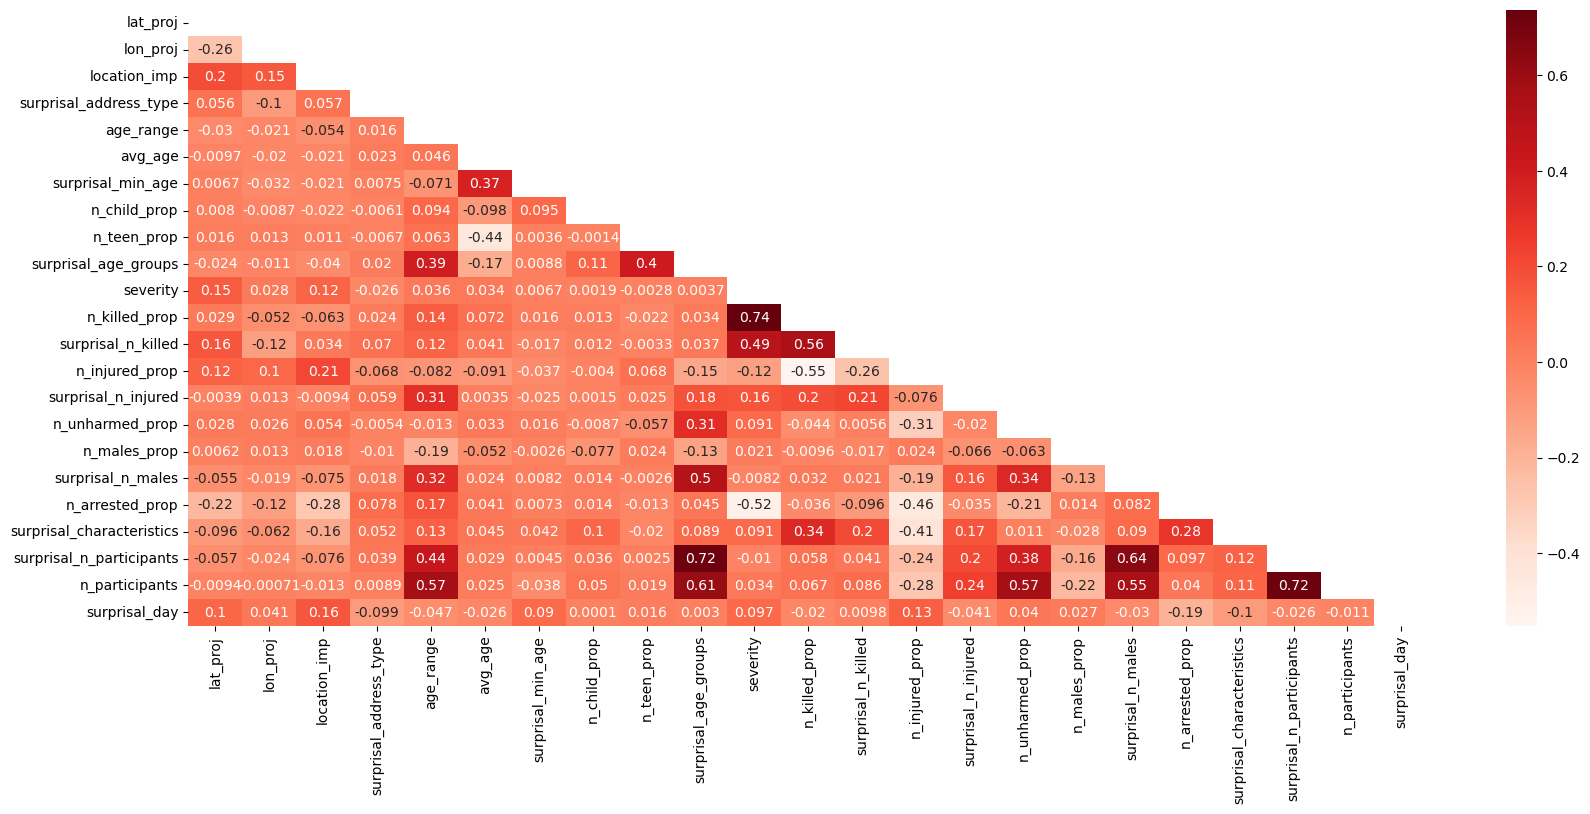

In [6]:
corr_matrix_illinois = illinois_df[ind_names_list].dropna().corr('kendall')

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix_illinois, annot=True, cmap=plt.cm.Reds, mask=np.triu(corr_matrix_illinois))
plt.show()

In [7]:
ind_names_list = [
    # geo
    'surprisal_address_type',
    # age
    'avg_age',
    # participants
    'n_killed',
    'n_males_prop',
    'n_arrested_prop',
    'n_participants',
    ]

Below, we have reported the correlation matrix for the selected features along with a brief description of each.

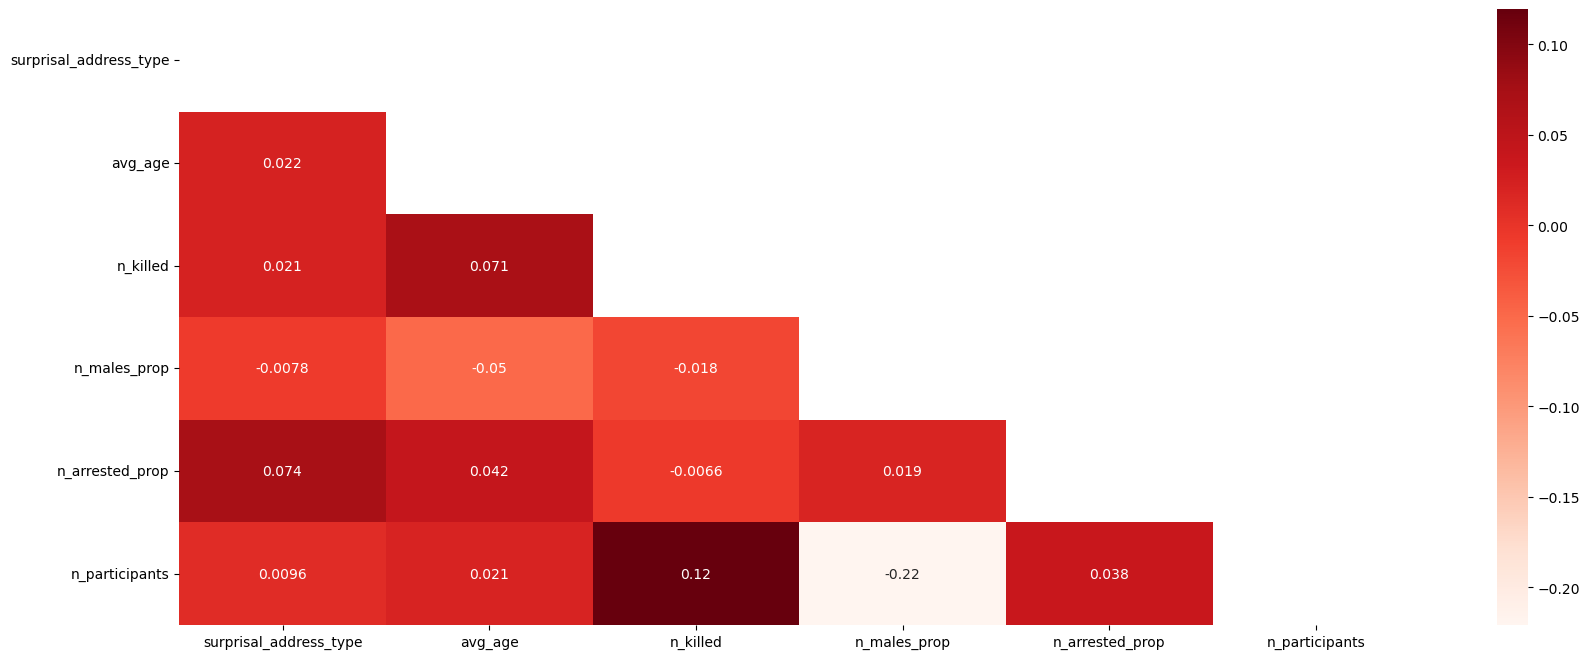

In [8]:
corr_matrix_illinois = illinois_df[ind_names_list].corr('kendall')

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix_illinois, annot=True, cmap=plt.cm.Reds, mask=np.triu(corr_matrix_illinois))
plt.show()

In [9]:
illinois_df[ind_names_list].describe()

surprisal_address_type       avg_age      n_killed  n_males_prop  \
count            16159.000000  14189.000000  17554.000000  15828.000000   
mean                 1.238483     27.073437      0.194201      0.898652   
std                  1.625750     10.094456      0.437058      0.250896   
min                 -0.000000      1.000000      0.000000      0.000000   
25%                  0.312384     20.000000      0.000000      1.000000   
50%                  0.368151     24.000000      0.000000      1.000000   
75%                  1.084064     31.000000      0.000000      1.000000   
max                  9.489848     91.000000      6.000000      1.000000   

       n_arrested_prop  n_participants  
count     16241.000000    16418.000000  
mean          0.127019        1.691497  
std           0.305846        0.968796  
min           0.000000        1.000000  
25%           0.000000        1.000000  
50%           0.000000        1.000000  
75%           0.000000        2.000000  
max           1.000000       20.000000

We observe that the selected features exhibit low correlation among themselves and display distinct value ranges.

## Utilities

In this section, we have prepared several useful functions for conducting clustering analysis. Here is a brief documentation for each function:

1. **Function: standardization**
   - Description: Standardizes data in the input dataframe (*df*) within the specified columns using either the 'Z-score' or 'MinMax' standardization methods. Both methods are implemented using objects imported from the sklearn library.
   - Input:
     - *df*: Input dataframe containing columns to be standardized.
     - *columns*: List of column names to be standardized.
     - *method*: The method of standardization to be used, either 'Z-score' or 'MinMax'.
   - Output:
     - A *np.ndarray* with the specified columns standardized.

2. **Function: find_best_eps**
   - Description: Implements the knee method to select the best candidates as values of *eps* for all the *min_samples* tried. Euclidean distance is used for this selection.
   - Input:
     - *X*: Input data array.
     - *min_samples_range*: Range of values for *min_samples* parameter.
   - Output:
     - Plot the graph of distance from k-th nearest neighbour

3. **Function: dbscan**
   - Description: Performs the DBSCAN algorithm using the **DBSCAN** library from sklearn.cluster. The function returns a dictionary containing *eps* and *min_samples* given as input, the estimated number of noise points, the estimated number of clusters, and the silhouette coefficient. This function is used to select the best parameters (*eps* and *min_samples*).
   - Input:
     - *X*: Input data array.
     - *eps*: Maximum distance between two samples for them to be considered in the same neighborhood.
     - *min_samples*: Minimum number of points needed to create a cluster.
   - Output:
     - A dictionary containing information about the clustering results.

We have chosen to use the silhouette coefficient as a measure to evaluate the algorithm's performance. The silhouette coefficient ranges from -1 to +1, where a higher value indicates that objects are well-matched to their own cluster and poorly matched to neighboring clusters.

### Standardize Data

In [10]:
def standardization(df, columns, standardizer='Zscore'):
    if standardizer == 'Zscore':
        standardizer = StandardScaler()
    if standardizer == 'MinMax':
        standardizer = MinMaxScaler()
    scaler = StandardScaler()
    scaler.fit(df[columns].values)
    return scaler.transform(df[columns].values)

### Find best EPS

In [11]:
def find_best_eps(X, min_samples_range=[3, 5, 9, 15]):
    dist = pdist(X, 'euclidean') # pair wise distance
    dist = squareform(dist) # distance matrix given the vector dist
    
    # Calculate sorted list of distances for points for each k in k_list
    # and plot the graph of distance from k-th nearest neighbour
    fig, ax = plt.subplots(int(np.ceil(len(min_samples_range)/3)), 3, figsize=(20, 8))

    for i, k in enumerate(min_samples_range):
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])

        # Plot the graph of distance from k-th nearest neighbour
        ax[int(i/3), int(i%3)].plot(range(0, len(kth_distances)), sorted(kth_distances))
        ax[int(i/3), int(i%3)].set_ylabel('%sth near neighbor distance' %k)
        ax[int(i/3), int(i%3)].set_xlabel('Point Sorted according to distance of %sth near neighbor' %k)
        ax[int(i/3), int(i%3)].tick_params(axis='both', which='major', labelsize=8)
        ax[int(i/3), int(i%3)].grid(linestyle='--', linewidth=0.5, alpha=0.6)

    plt.show()

### DBASCAN Algorithm

In [12]:
def dbscan(X, eps=0.1, min_samples=10):
    # Compute DBSCAN      
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    return {'eps': eps, 'min_samples': min_samples, 
        '#clusters': len(set(labels)) - (1 if -1 in labels else 0),
        '#noise': list(labels).count(-1),  '%noise': list(labels).count(-1)/X.shape[0]*100,
        'silhouette_coef': metrics.silhouette_score(X, labels), 
        '#cluster0': list(labels).count(0), '#cluster1': list(labels).count(1), 
        '#cluster2': list(labels).count(2), '#cluster3': list(labels).count(3), 
        '#cluster4': list(labels).count(4), '#cluster5': list(labels).count(5),
        '#cluster6': list(labels).count(6), '#cluster7': list(labels).count(7)}

## DBSCAN Algorithm: Illinois

### Prepare Data and Parameters selection

We prepare the data by selecting only the entries in the dataset corresponding to the Illinois state and where all the values corresponding to the selected attributes, on which the clustering algorithm operates, are not NaN. Since the data have different range values for the various attributes, we decided to standardize using the 'MinMax' scaler, which, from some preliminary trials, has proven to be the most effective.

We also save all the attribute values for the entries we use in the dataframe *illinois_df*.

In [13]:
X_minmax_illinois = standardization(
    df=incidents_df[incidents_df['state']=='ILLINOIS'][ind_names_list].dropna(), 
    columns=ind_names_list, standardizer='MinMax')

In [14]:
illinois_df = incidents_df.loc[incidents_df[incidents_df['state']=='ILLINOIS'][ind_names_list].dropna().index]

In [15]:
illinois_df.shape

(13234, 91)

We plot boxplots representing the various attributes of our standardized data, revealing the presence of numerous outliers.

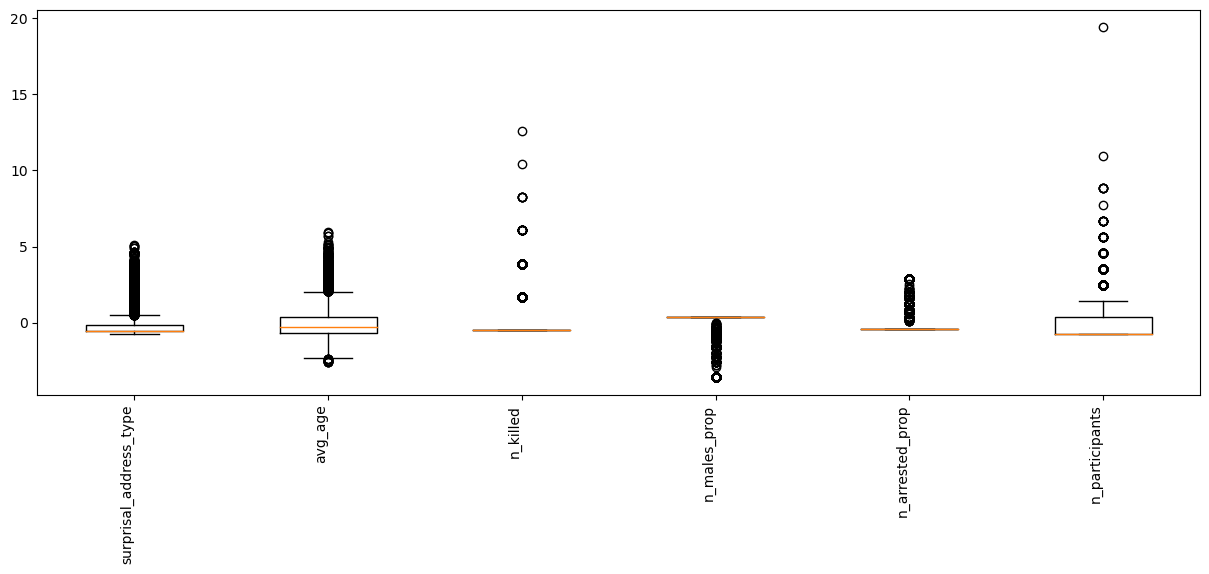

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.boxplot(X_minmax_illinois, vert=True, labels=ind_names_list)
plt.xticks(rotation=90, ha='right')
plt.show()

We utilize the Kneed algorithm to identify the range for the optimal epsilon *eps*.

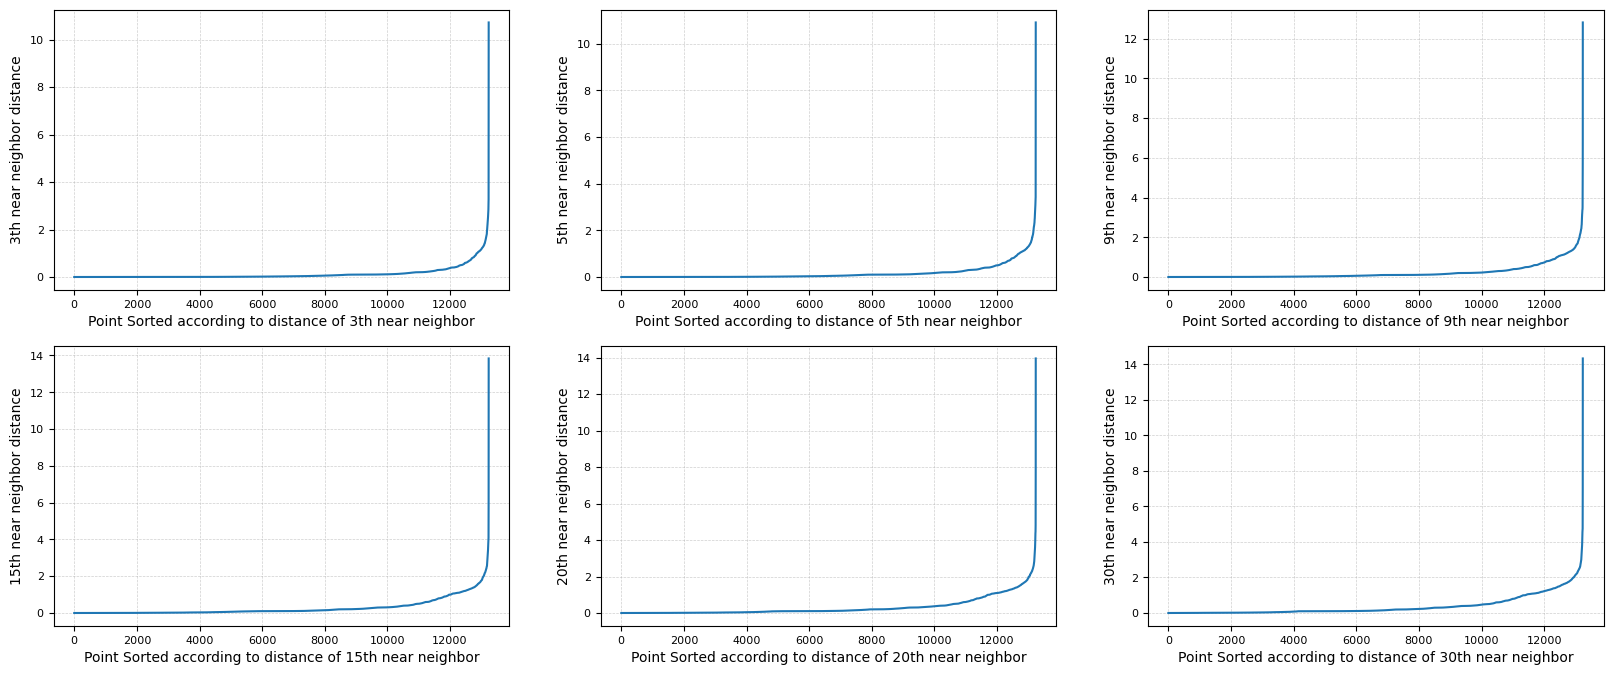

In [17]:
find_best_eps(X_minmax_illinois, min_samples_range=[3, 5, 9, 15, 20, 30])

Upon examining the plot, we decide to explore epsilon values in the range between 1.25 and 2.

In [18]:
eps = [1.25, 1.5, 1.75, 2]
# eps: maximum distance between two samples for one to be considered as in the neighborhood of the other.
min_samples = [7, 12, 20]

dbscan_illinois = pd.DataFrame(columns=['eps', 'min_samples', '#clusters', '#noise', '%noise', 'silhouette_coef',
    '#cluster0', '#cluster1', '#cluster2', '#cluster3', '#cluster4', '#cluster5', '#cluster6', '#cluster7'])

for e in eps:
    for k in min_samples:
        db = dbscan(X_minmax_illinois, eps=e, min_samples=k)
        dbscan_illinois = pd.concat([dbscan_illinois, pd.DataFrame(db, index=[0])], ignore_index=True)

In [19]:
dbscan_illinois

eps min_samples #clusters #noise    %noise  silhouette_coef #cluster0  \
0   1.25           7        11    167  1.261901         0.193213      2364   
1   1.25          12        10    255  1.926855         0.190003      2344   
2   1.25          20         9    398  3.007405         0.165563      2313   
3   1.50           7         5     83  0.627172         0.221301      2441   
4   1.50          12         5    111  0.838749         0.218640      2429   
5   1.50          20         6    168  1.269457         0.251352      2422   
6   1.75           7         4     61  0.460934         0.232278      2511   
7   1.75          12         4     72  0.544053         0.231267      2502   
8   1.75          20         4    102  0.770742         0.228365      2494   
9   2.00           7         4     38  0.287139         0.242452      2521   
10  2.00          12         3     54  0.408040         0.242566      2515   
11  2.00          20         3     69  0.521384         0.240740      2507   

   #cluster1 #cluster2 #cluster3 #cluster4 #cluster5 #cluster6 #cluster7  
0       9793       117        69       501        43        49        57  
1       9771       114       498        59        39        45        56  
2       9752        94       496        48        36        39        43  
3      10466       140        43        61         0         0         0  
4      10459       135        43        57         0         0         0  
5       9941       110       498        42        53         0         0  
6      10475       144        43         0         0         0         0  
7      10475       142        43         0         0         0         0  
8      10472       124        42         0         0         0         0  
9      10521       146         8         0         0         0         0  
10     10520       145         0         0         0         0         0  
11     10519       139         0         0         0         0         0

The selection of *eps* and *min_samples* was based on the silhouette coefficient, the number of clusters, their size, and the noise detected. 

Preliminary trials were conducted to choose appropriate coefficients. 
We decided not to use *min_samples* greater than 20 since the algorithm struggled to find a suitable number of clusters, either grouping everything into a single cluster or forming multiple clusters, one of which contained almost all the data. In these cases, the silhouette coefficient appeared higher, but the result was unsatisfactory and lacked significance. 

Therefore, we opted for *min_samples=20* and *eps=1.5*.

### Perform Clustering

We selected *eps* = 1.5 and *min-samples* = 20

In [20]:
db = DBSCAN(eps=1.5, min_samples=20).fit(X_minmax_illinois) # 5 first trial

In [21]:
illinois_df['cluster'] = db.labels_ # save cluster labels in dataframe

In [22]:
print('Silhouette Coefficient: %0.6f' %
    silhouette_score(X_minmax_illinois, db.labels_))

Silhouette Coefficient: 0.251352


### Save cluster

We save the clusters labels in a csv file, in order to use them for a cluster comparison analysis.

In [23]:
illinois_df['cluster'].to_csv('../data/clustering_labels/DBSCAN_clusters.csv', index=True)

## Metrics Visualization

We have plotted the distance matrix. The distance matrix shows a clear diagonal correlation, as indicated by the Pearson coefficient of 0.43.

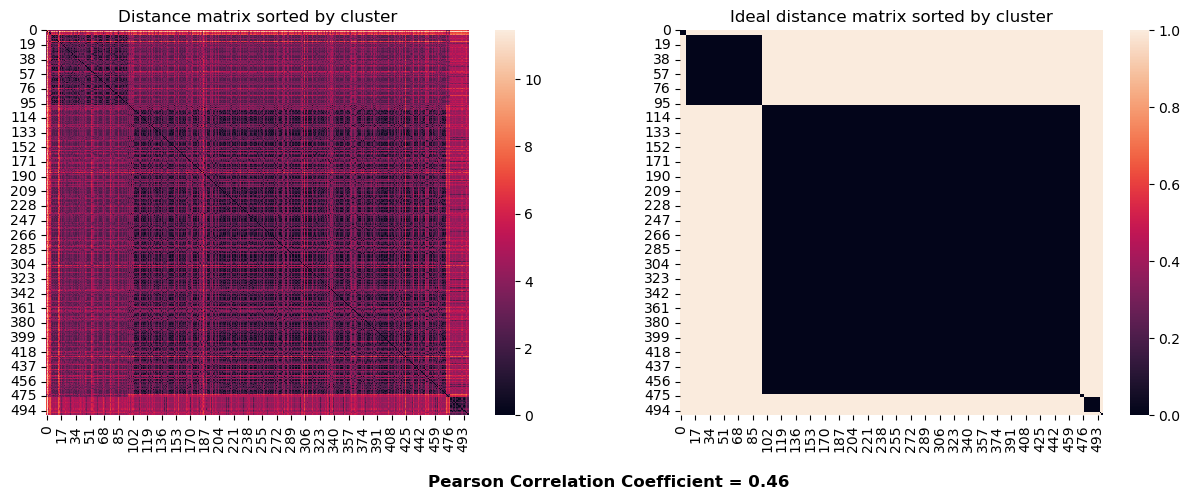

In [24]:
plot_distance_matrices(X=X_minmax_illinois, n_samples=500, clusters=db.labels_);

We have plotted the silhouette score for each point in each cluster. It is noticeable that clusters 0 and 1 (the most populated clusters) have a minority of points for which the silhouette score assumes negative values, indicating potential misclassifications or less distinct clusters. On the other hand, higher silhouette values are achieved by clusters 5 and 6 (the least populated ones), suggesting a clearer separation of points within these clusters.

In [25]:
def plot_scores_per_point(score_per_point, clusters, score_name, ax, color_palette=sns.color_palette(), title=None, minx=-0.1):
    '''
    This function plots the clustering score for each point, grouped by cluster.

    :param score_per_point: clustering score for each point
    :param clusters: cluster labels
    :param score_name: name of the clustering score
    :param ax: axis to plot on
    :param color_palette: color palette to use
    :param title: title of the plot
    '''

    n_clusters = len(np.unique(clusters))
    y_lower = 0
    for i in range(n_clusters):
        ith_cluster_sse = score_per_point[np.where(clusters == i)[0]]
        ith_cluster_sse.sort()
        size_cluster_i = ith_cluster_sse.shape[0]
        y_upper = y_lower + size_cluster_i
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_sse,
            facecolor=color_palette[i],
            edgecolor=color_palette[i],
            alpha=0.7,
        )
        ax.text(minx+0.1*i, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper

    ax.axvline(x=score_per_point.mean(), color="k", linestyle="--", label='Average')
    if title is None:
        title = f"{score_name} for each point in each cluster"
    ax.set_title(title)
    ax.set_xlabel(score_name)
    ax.set_ylabel("Cluster label")
    ax.legend(loc='best')
    ax.set_yticks([])

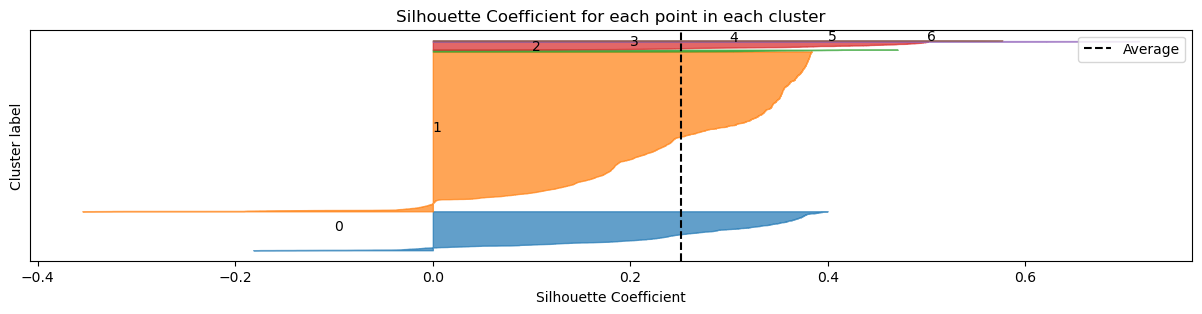

In [26]:
fig, ax = plt.subplots(figsize=(15, 3))
plot_scores_per_point(score_per_point=silhouette_samples(X=X_minmax_illinois, labels=db.labels_), 
    clusters=db.labels_, score_name='Silhouette Coefficient', ax=ax)

We saved the silhouette score in a dataframe for later comparison with other clustering algorithms. It's important to note that, in the case of DBSCAN, the silhouette score is not an ideal metric for evaluating clustering since DBSCAN is not a partitioning algorithm. A more meaningful interpretation can be derived using the silhouette score per point, as demonstrated earlier.

In the dataframe, additional columns include other metrics to make it compatible with the metrics dataframe we will use for other clustering algorithms.

In [27]:
results_df = pd.DataFrame(columns=['BSS', 'SSE', 'calinski_harabasz_score',
    'calinski_harabasz_score', 'davies_bouldin_score', 'model', 'n_iter', 'silhouette_score'], index=range(1))


results_df['model'] = 'DBSCAN(eps=1.5, min_samples=20)'
results_df['silhouette_score'] = silhouette_score(X_minmax_illinois, db.labels_)

In [28]:
results_df

BSS  SSE calinski_harabasz_score calinski_harabasz_score  \
0  NaN  NaN                     NaN                     NaN   

  davies_bouldin_score                            model n_iter  \
0                  NaN  DBSCAN(eps=1.5, min_samples=20)    NaN   

   silhouette_score  
0          0.251352

We computed the same external metrics as well. It's noteworthy that the metrics for the *death* category, which represents incidents involving at least one fatality, are quite promising. These external metrics have been calculated for a subsequent comparative analysis between clustering algorithms.

In [29]:
illinois_df['unharmed'] = illinois_df['n_unharmed'] > 0
illinois_df['arrested'] = illinois_df['n_arrested'] > 0
illinois_df['males'] = illinois_df['n_males'] > 0
illinois_df['females'] = illinois_df['n_females'] > 0

external_scores_df = compute_permutation_invariant_external_metrics(
    illinois_df,
    'cluster',
    ['shots', 'aggression', 'suicide', 'injuries', 'death', 'drugs', 'illegal_holding', 'unharmed', 'arrested','males', 'females']
)

external_scores_df

adjusted rand score  normalized mutual information  \
feature                                                               
shots                      -0.075938                       0.047912   
aggression                  0.364733                       0.212332   
suicide                     0.039015                       0.035117   
injuries                    0.352241                       0.234914   
death                       0.837984                       0.772892   
drugs                      -0.007725                       0.003725   
illegal_holding            -0.038983                       0.008984   
unharmed                   -0.029378                       0.009844   
arrested                    0.000346                       0.026035   
males                       0.254814                       0.375474   
females                     0.233199                       0.202374   

                 homogeneity  completeness  
feature                                     
shots               0.084670      0.033408  
aggression          0.263700      0.177713  
suicide             0.295749      0.018667  
injuries            0.271139      0.207227  
death               0.985145      0.635888  
drugs               0.016119      0.002106  
illegal_holding     0.020715      0.005736  
unharmed            0.011332      0.008701  
arrested            0.035774      0.020464  
males               0.967651      0.232929  
females             0.308043      0.150685

In [30]:
results_df.to_csv(f'../data/clustering_labels/DBSCAN_internal_scores.csv')
external_scores_df.to_csv(f'../data/clustering_labels/DBSCAN_external_scores.csv')

## Results 

Below, we visualize how the algorithm divided the data into clusters.

From the barplot below, we can clearly see that the clusters are not balanced; the majority of entries (9941 over 13234) are contained in one cluster.

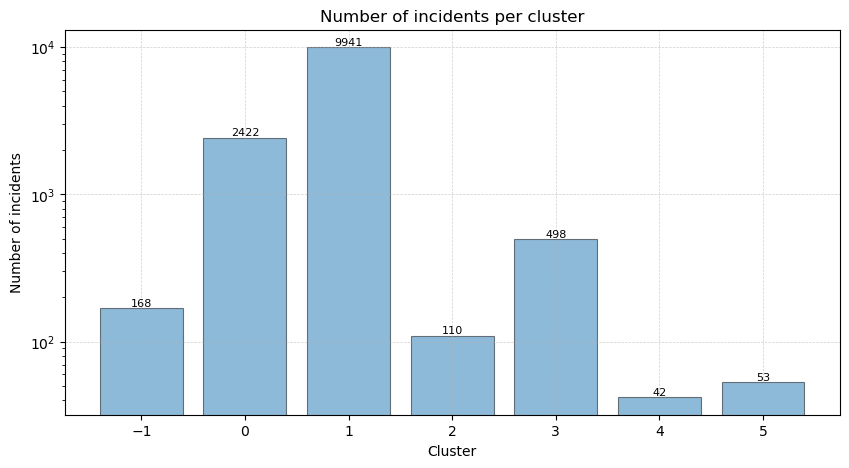

In [31]:
# bar plot of number of incidents per cluster
cluster_counts = pd.Series(db.labels_).value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(cluster_counts.index, cluster_counts.values, edgecolor='black', linewidth=0.8, alpha=0.5)
plt.xlabel('Cluster')
plt.xticks(cluster_counts.index)
plt.ylabel('Number of incidents')
plt.yscale('log')
for i, v in enumerate(cluster_counts.values):
    plt.text(x=i-1, y=v, s=str(v), horizontalalignment='center', verticalalignment='bottom', fontsize=8)
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.title('Number of incidents per cluster')
plt.show()

We visualize clusters by plotting the divisions between all dimensions using Seaborn's pairplot.

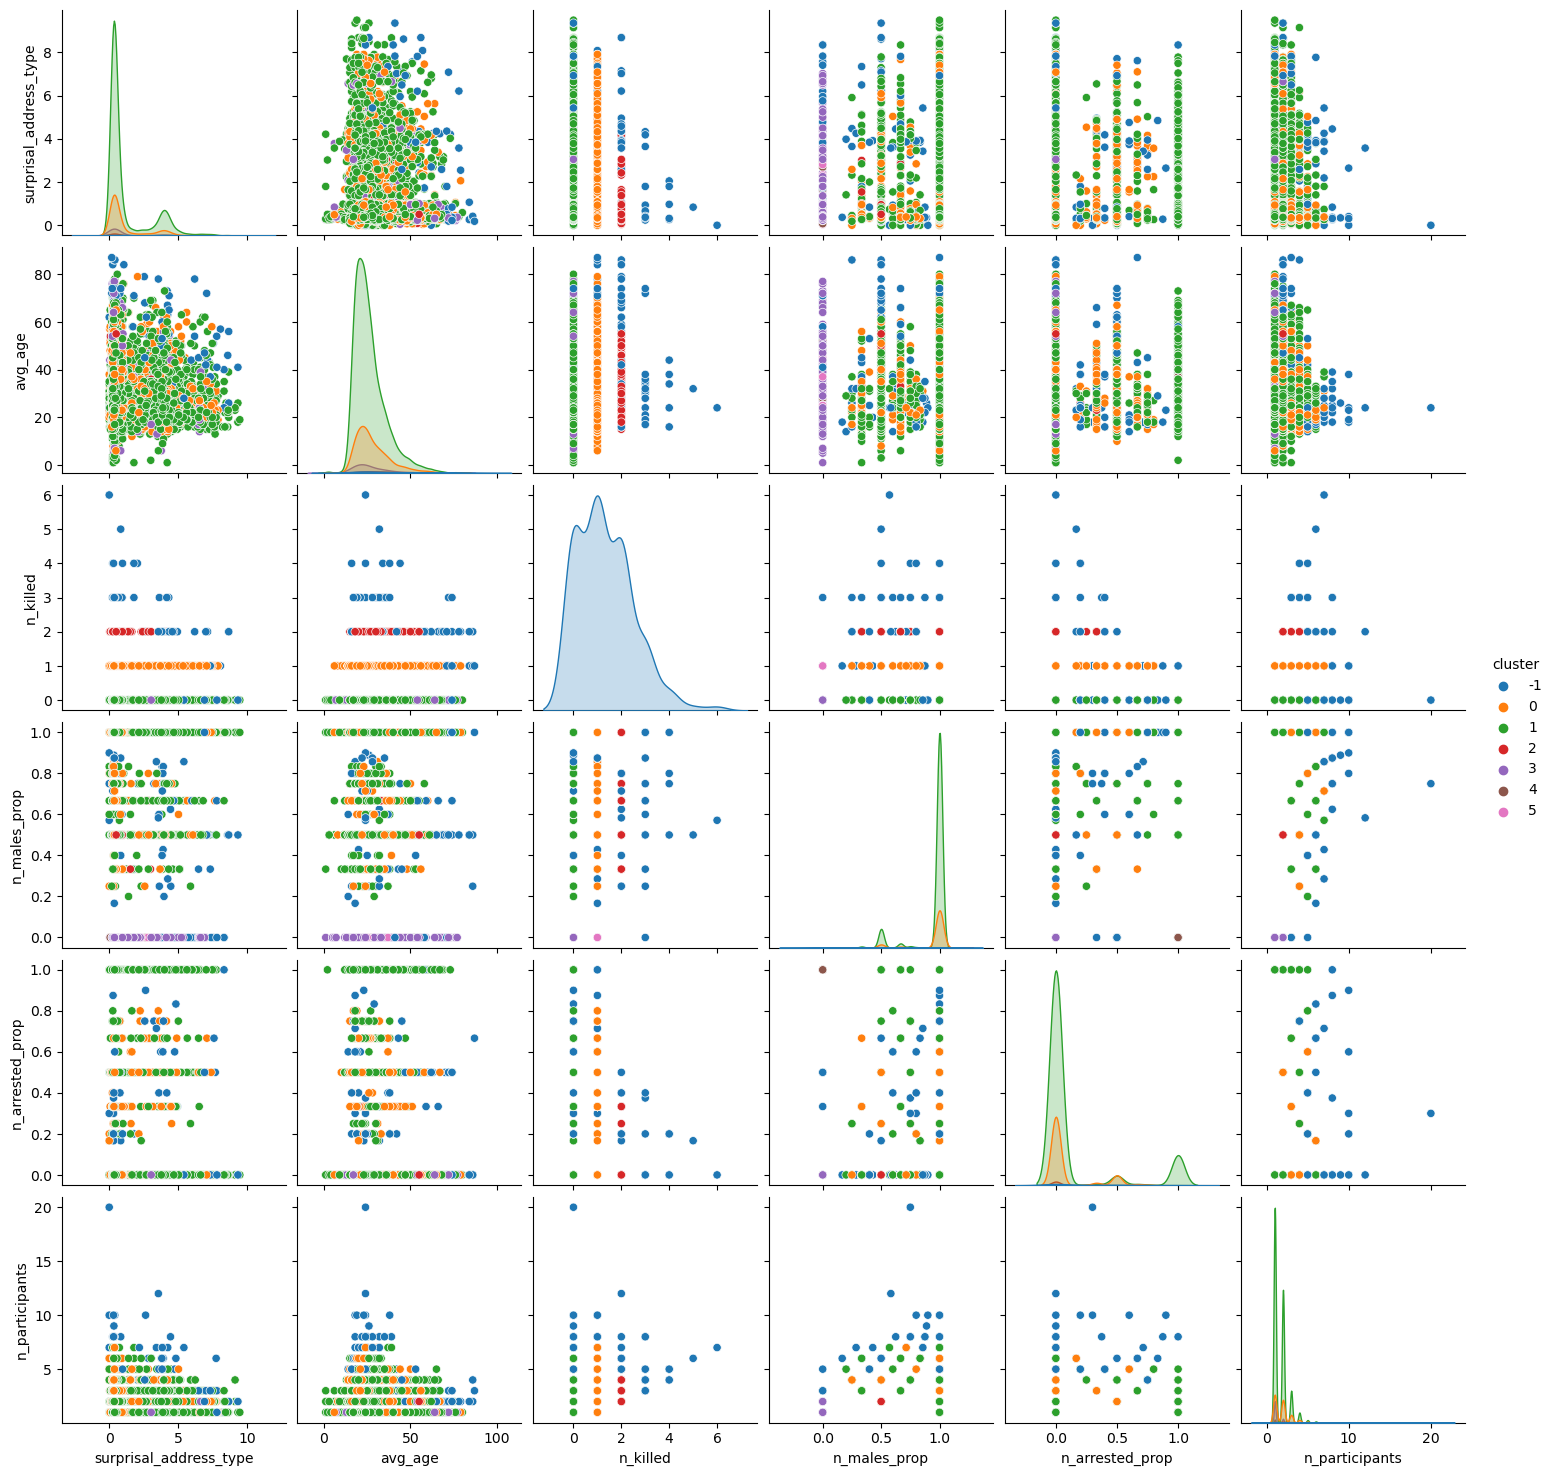

In [32]:
sns.pairplot(illinois_df, hue='cluster', palette=sns.color_palette(
    n_colors=illinois_df['cluster'].unique().shape[0]), vars=ind_names_list)
plt.show()

From this plot, we can observe that clusters seem to divide the data based on 'n_killed.'

We plot the data distribution between clusters for 'avg_age' and 'surprisal_address_type' use Plotly for the same visualization to obtain a clearer view and better understand how noise is distributed

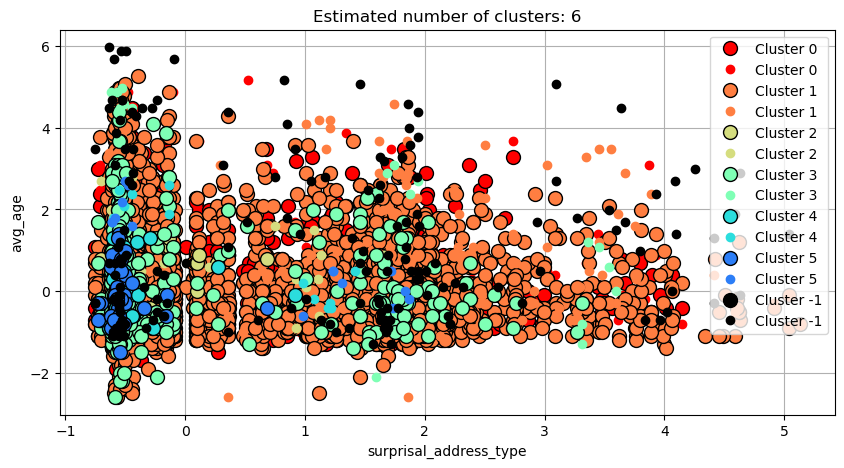

In [33]:
plot_dbscan(X=X_minmax_illinois, db=db, columns=[0,1], axis_labels=ind_names_list[:2], figsize=(10, 5))
# 'surprisal_address_type': column 0 in X_minmax_illinois
# 'avg_age': column 1 in X_minmax_illinois

From the plot w can observe that class -1 in black represents the noise points, points with a black border represent the core points of the cluster, while points without a border are the border points.

From this plot, a precise division of the clusters does not appear. Cluster 5 seems to occupy points where 'surprisal_address_type' mostly takes negative values. A similar trend can be observed for cluster 3.

Clusters 0 and 1 (the most populated ones) seem to have a uniform distribution across the data, and a similar observation applies to the noise points.

Below, we plot some histograms to better visualize how data with the same values in each feature are divided into clusters.

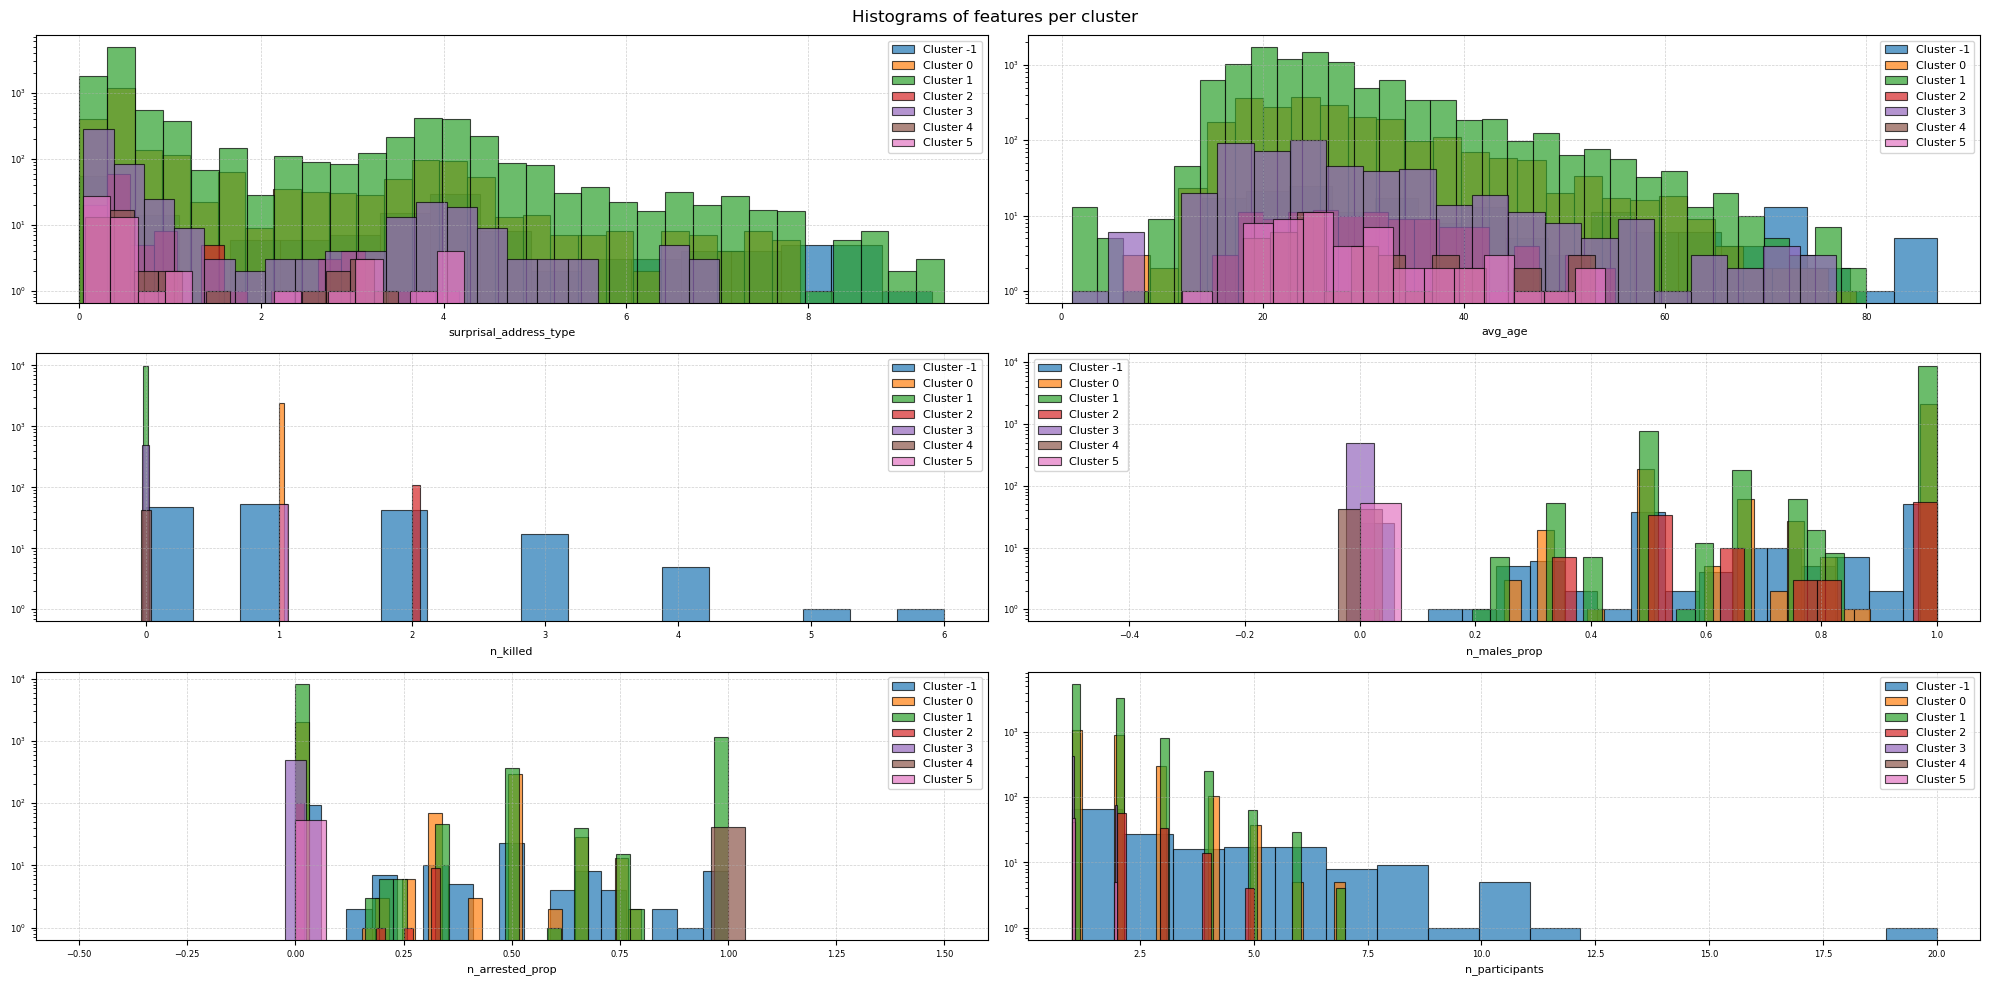

In [34]:
fig, ax = plt.subplots(3, 2, figsize=(20, 10), sharex=False, sharey=False)
index = 0
for i in range(6):
    for cluster in np.unique(db.labels_):
        ax[int(index/2), index%2].hist(illinois_df[illinois_df['cluster']==cluster][ind_names_list[i]], 
            bins=int(1+3.3*np.log(illinois_df[illinois_df['cluster']==cluster].shape[0])), 
            label=f'Cluster {cluster}', edgecolor='black', linewidth=0.8, alpha=0.7)
    ax[int(index/2), index%2].set_xlabel(ind_names_list[i], fontsize=8)
    ax[int(index/2), index%2].set_yscale('log')
    ax[int(index/2), index%2].tick_params(axis='both', which='major', labelsize=6)
    ax[int(index/2), index%2].legend(fontsize=8)
    ax[int(index/2), index%2].grid(linestyle='--', linewidth=0.5, alpha=0.6)
    index += 1
fig.suptitle('Histograms of features per cluster')
fig.tight_layout()
plt.show()

Already, we can see the division by cluster for 'n_killed', the other features seem to be uniformly distributed across the cluster classes.

Below, we represent the same data as before, but in a histogram for each cluster and each feature, making it more comprehensible.

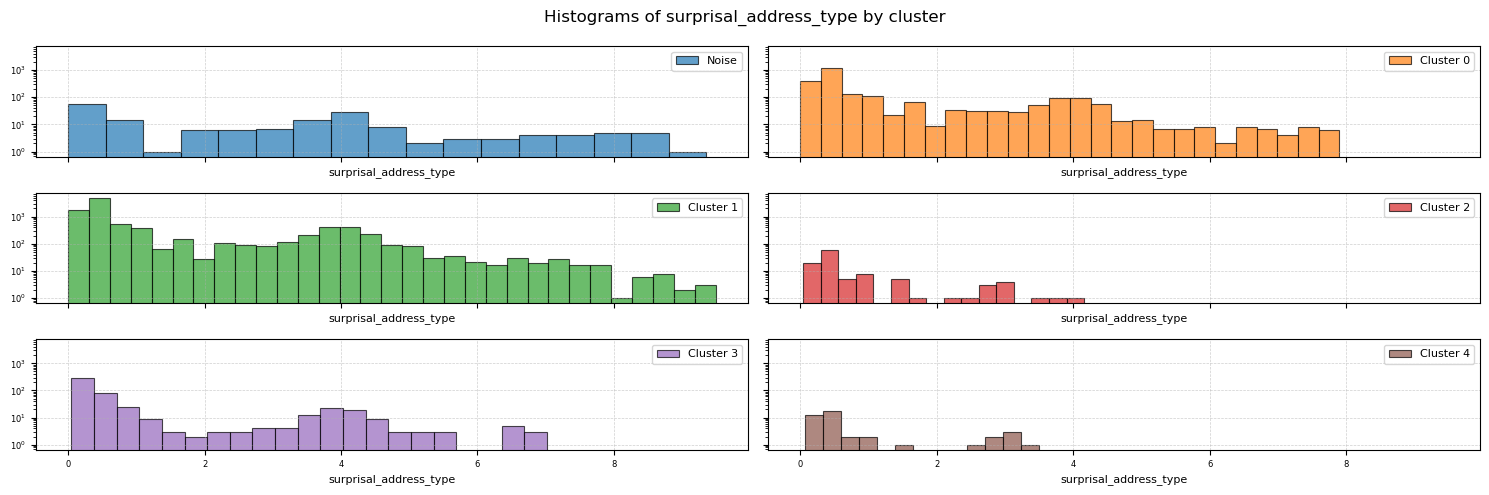

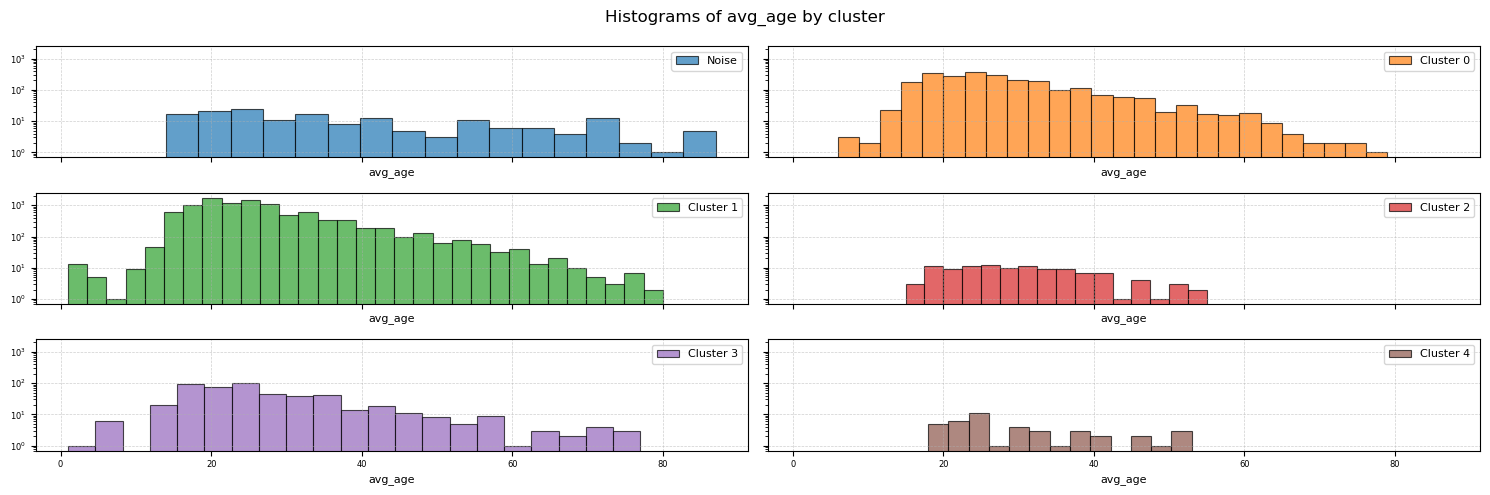

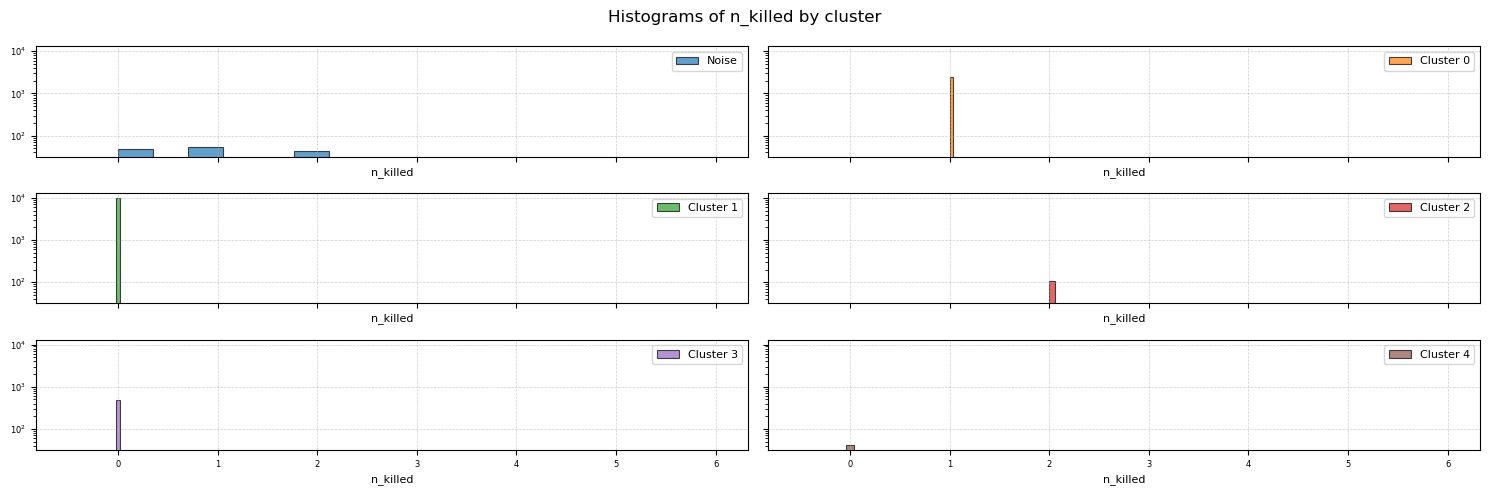

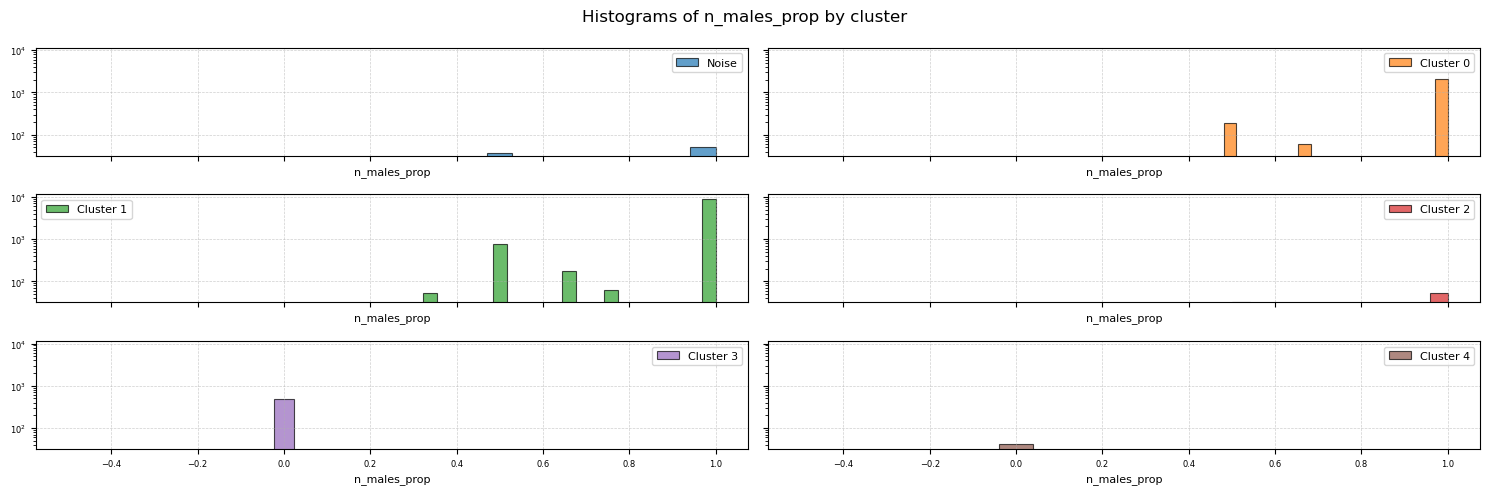

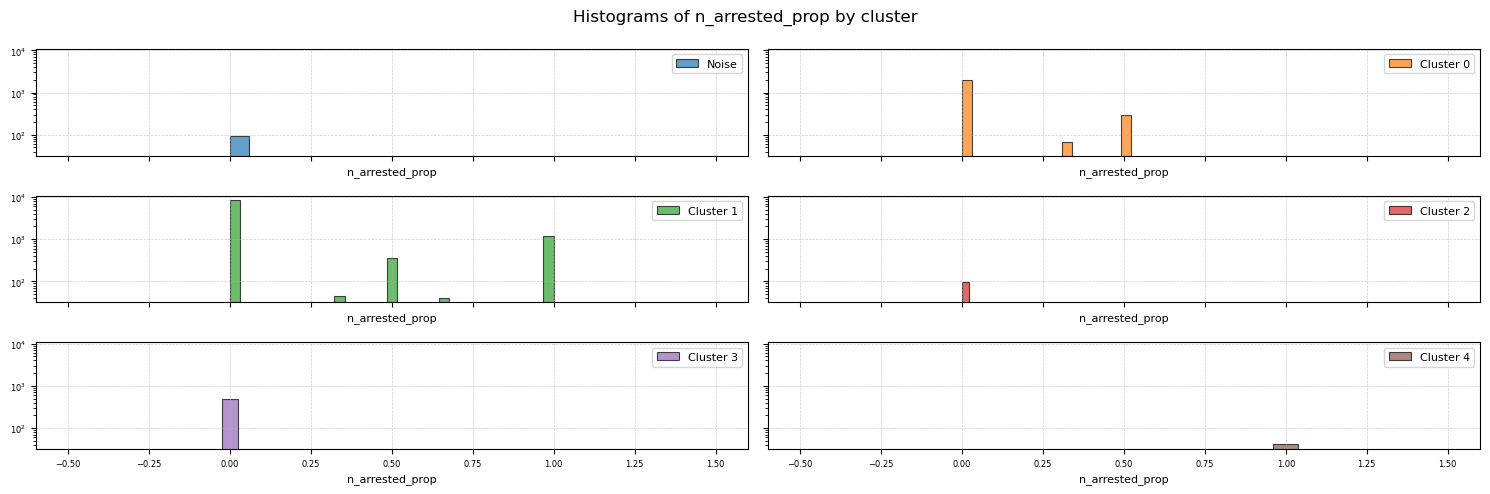

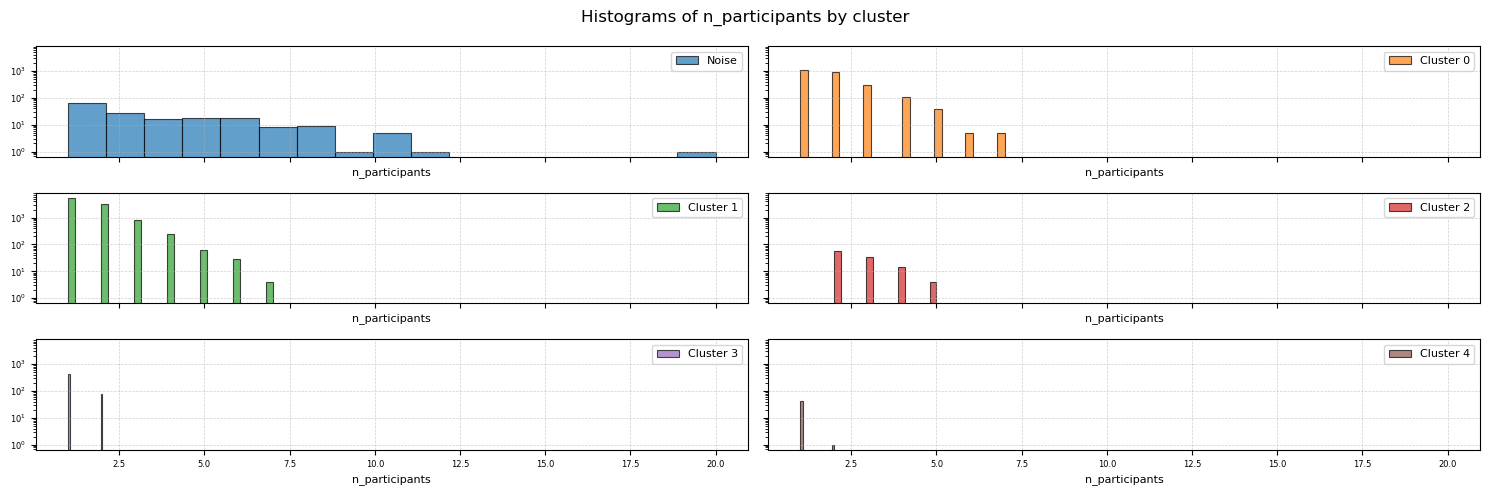

In [35]:
for column in ind_names_list:
    plot_hists_by_cluster_dbscan(df=illinois_df, db=db, column=column, figsize=(15, 5))

From this representation, we can better visualize the data distribution across clusters. For 'surprisal_address_type' and 'avg_age', the division of data into clusters appears homogeneous, and so does the noise. We can conclude that the cluster does not exhibit significant variations in these features.

A similar observation can be made for the number of participants, where we also notice that all data with a number of participants greater than 6 have been classified as noise, as they are indeed outliers in the distribution of data for the number of participants, both in the data used for clustering and in the entire dataset.

Regarding 'n_killed', as seen before, the clusters have divided the data based on this value. 

For 'n_arrested_prop', in clusters 2 and 3, there are only data with values close to 0 (left margin), in cluster 4, only data with values close to 1 (right margin), and in clusters 0 and 1 (the most populated ones), the values seem to be uniformly distributed.

Similarly, for 'n_males_prop', clusters 0 and 1 exhibit a distribution similar to 'n_arrested_prop', clusters 2 and 3 show marginal values near 0, and cluster 4 has marginal values near 1.

In conclusion, the algorithm has clustered the data, demonstrating clear divisions based on certain features such as 'n_killed,' 'n_arrested_prop,' and 'n_males_prop.' 
However, for features like 'surprisal_address_type' and 'avg_age,' the clusters appear to exhibit homogeneity.
The algorithm also effectively identifies outliers points, particularly for instances with a high number of participants.

### Visualize Clusters on a Map

We plot the clusters on an Illinois map to visualize their geographical distribution.

In [36]:
plot_scattermap_plotly(illinois_df, 'cluster', zoom=5, title='Incidents clustered by DBSCAN')

Since the majority of incidents in our dataset in the state of Illinois are situated in Cook County, we also provide a zoomed-in view of that county for visualization purposes."

In [37]:
plot_scattermap_plotly(illinois_df[illinois_df['county']=='Cook County'], 'cluster', 
    zoom=8, title='Incidents clustered by DBSCAN')

No discernible patterns are observed; data points belonging to each cluster appear to be uniformly distributed across the territory.

We use a choropleth map to visualize the the most frequent clusters for incidents in each county in Illinois.

In [38]:
cluster_df = pd.DataFrame()
cluster_df['county'] = illinois_df['county']
cluster_df['county'] = cluster_df['county'].str.replace(' County', '')
cluster_df['county'] = cluster_df['county'].str.replace('Saint Clair', 'St. Clair')
cluster_df['county'] = cluster_df['county'].str.replace('DeWitt', 'De Witt')
cluster_df['cluster'] = illinois_df['cluster']

illinois_map = gpd.read_file('../cb_2018_us_county_500k')
illinois_merged = illinois_map.merge(cluster_df, left_on='NAME', right_on='county')
illinois_merged = illinois_merged[illinois_merged['STATEFP']=='17']

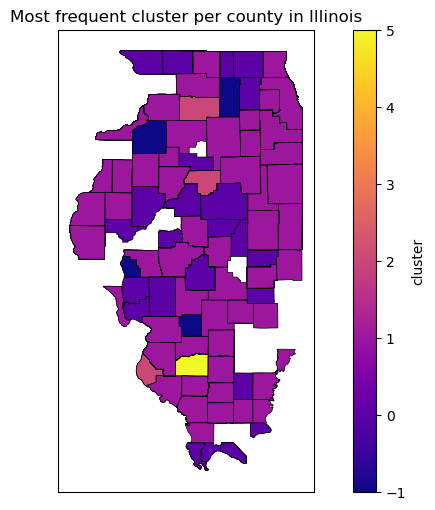

In [39]:
vmin, vmax = illinois_merged['cluster'].agg(['min', 'max'])
illinois_merged.plot(column='cluster', cmap='plasma', figsize=(10, 6), vmin=vmin, vmax=vmax,
    legend=True, legend_kwds={'label': 'cluster', 'shrink': 1}, edgecolor='black', linewidth=0.5)
plt.title('Most frequent cluster per county in Illinois')
plt.xticks([])
plt.yticks([])
plt.show()

We can observe that clusters 0 and 1 are the most frequent plot, as we expected, since they are the most populated and 
the clusters distribuition sems to be uniform. 
We can also observe that in 3 county the most frequent cluster is 2, while in 1 county the most frequent cluster is 5.

## Analysis of Clustering Results Using External Features

In this section, we have examined the results of the clustering analysis, taking into account additional external features present in the dataset. Our goal is to explore how these clusters align with the identified external characteristics, providing a more comprehensive understanding of the overall dataset structure.

We considered the following features and indices:

In [40]:
features = [
    # number of participants
    'n_males', 'n_adult', 'n_injured', 'n_arrested', 'n_unharmed', 
    # age
    'n_child_prop', 'n_teen_prop', 'age_range', 
    # geographical
    'location_imp', 'congd',
    # characteristics
    'surprisal_characteristics', 
    # date
    'surprisal_day', 'year', 
    # external data
    'poverty_perc'
]

Below, we have plotted histograms for each of the selected features to visualize how incidents are distributed within the clusters based on feature values.

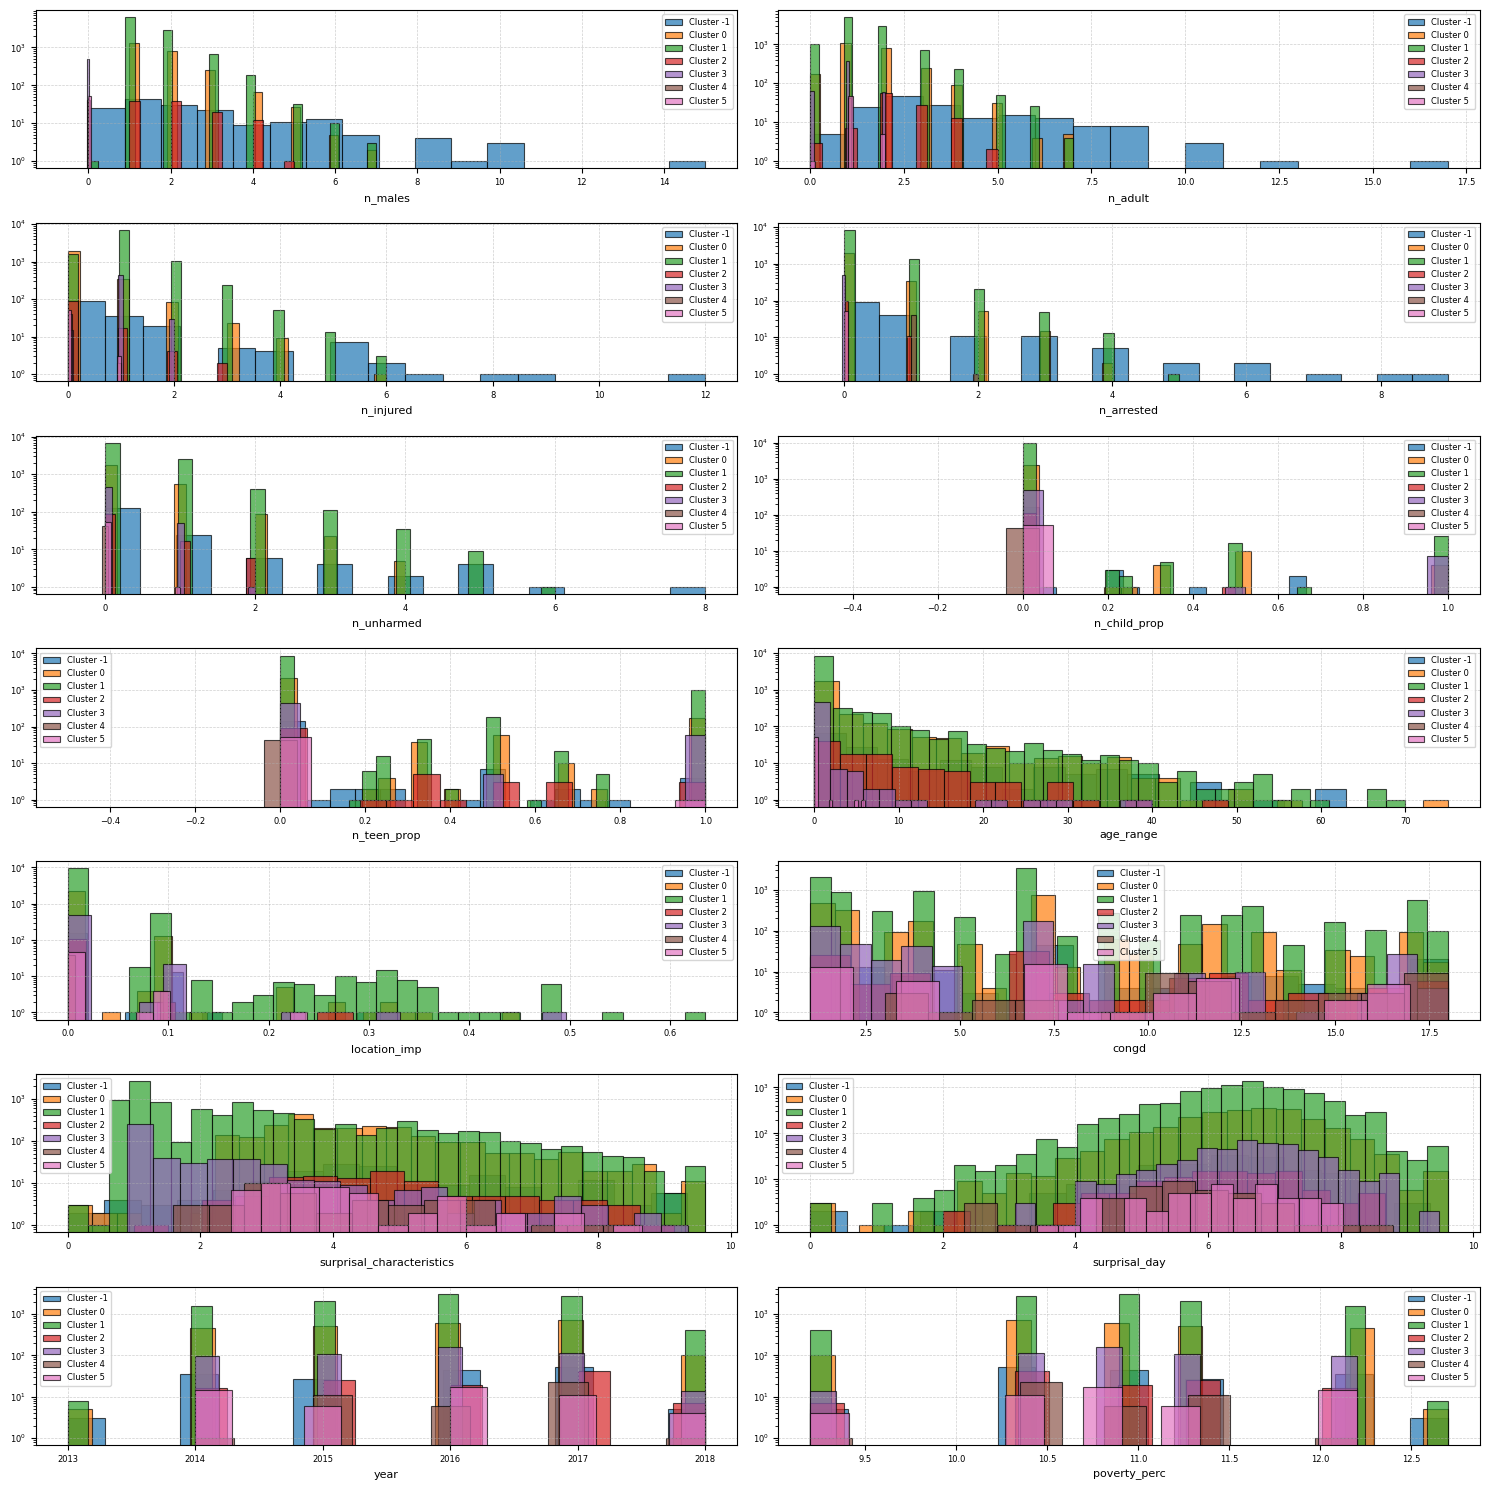

In [41]:
fig, ax = plt.subplots(7, 2, figsize=(15, 15), sharex=False, sharey=False)
for i in range(len(features)):
    for cluster in np.unique(db.labels_):
        ax[int(i/2), i%2].hist(illinois_df[illinois_df['cluster']==cluster][features[i]], 
            bins=int(1+3.3*np.log(illinois_df[illinois_df['cluster']==cluster].shape[0])), 
            label=f'Cluster {cluster}', edgecolor='black', linewidth=0.8, alpha=0.7)
    ax[int(i/2), i%2].set_xlabel(features[i], fontsize=8)
    ax[int(i/2), i%2].set_yscale('log')
    ax[int(i/2), i%2].tick_params(axis='both', which='major', labelsize=6)
    ax[int(i/2), i%2].legend(fontsize=6)
    ax[int(i/2), i%2].grid(linestyle='--', linewidth=0.5, alpha=0.6)
fig.tight_layout()
plt.show()

Despite the histograms not revealing a distinct pattern in the distribution of incidents within the clusters, we are exploring alternative visualization methods to uncover potential relationships or patterns that may not be evident in the current representations.

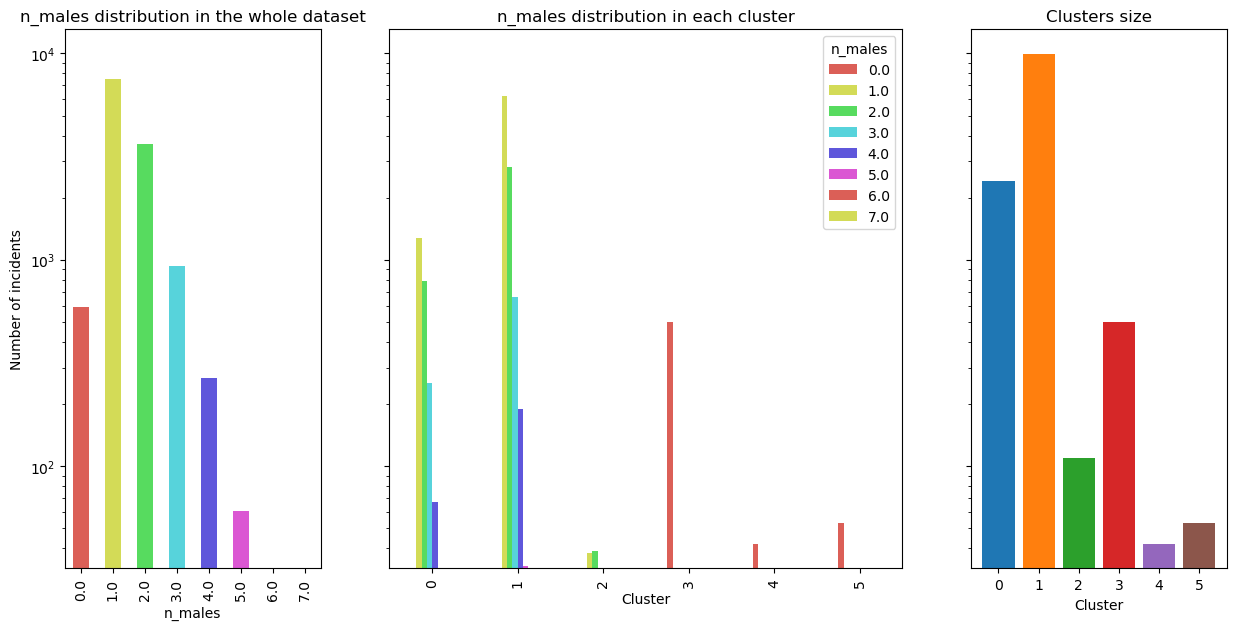

In [42]:
plot_bars_by_cluster(illinois_df[illinois_df['cluster']!=-1], feature='n_males', 
    cluster_column='cluster', figsize=(10, 5), log_scale=True)

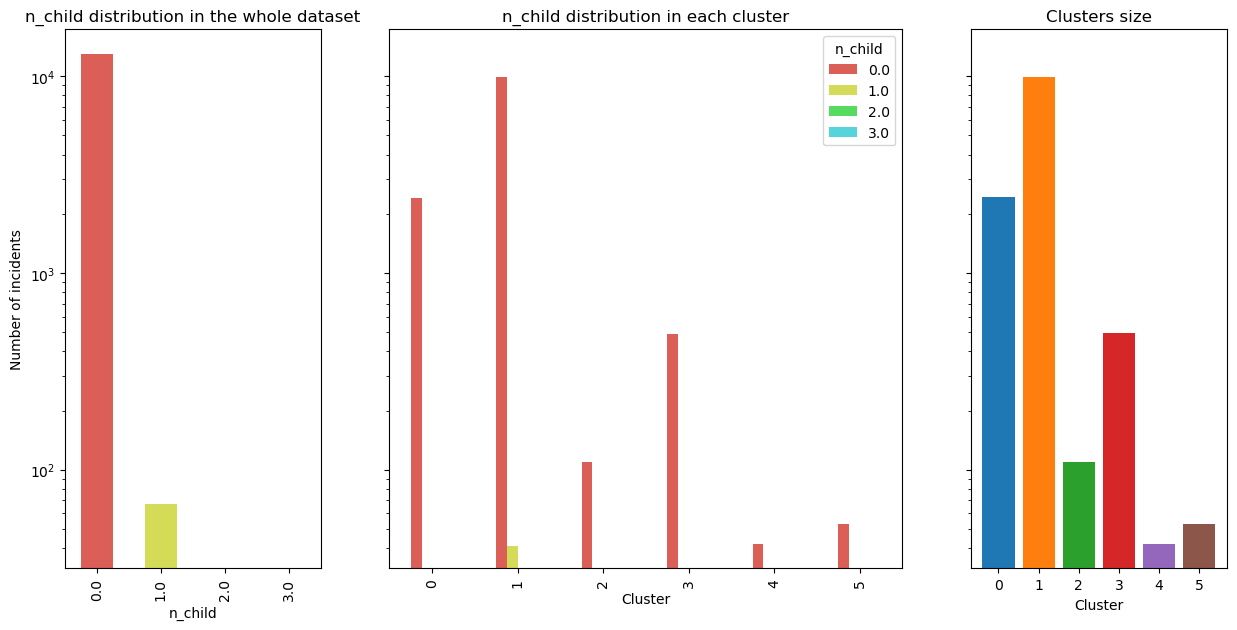

In [43]:
plot_bars_by_cluster(illinois_df[illinois_df['cluster']!=-1], feature='n_child', 
    cluster_column='cluster', figsize=(10, 5), log_scale=True)

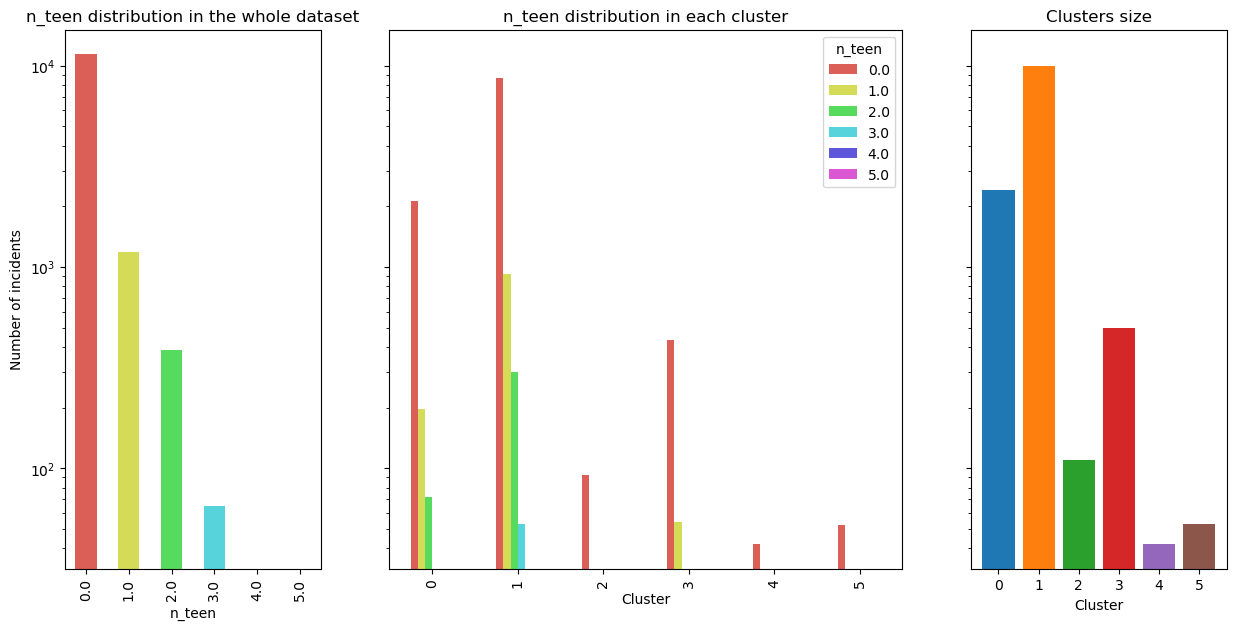

In [44]:
plot_bars_by_cluster(illinois_df[illinois_df['cluster']!=-1], feature='n_teen', 
    cluster_column='cluster', figsize=(10, 5), log_scale=True)

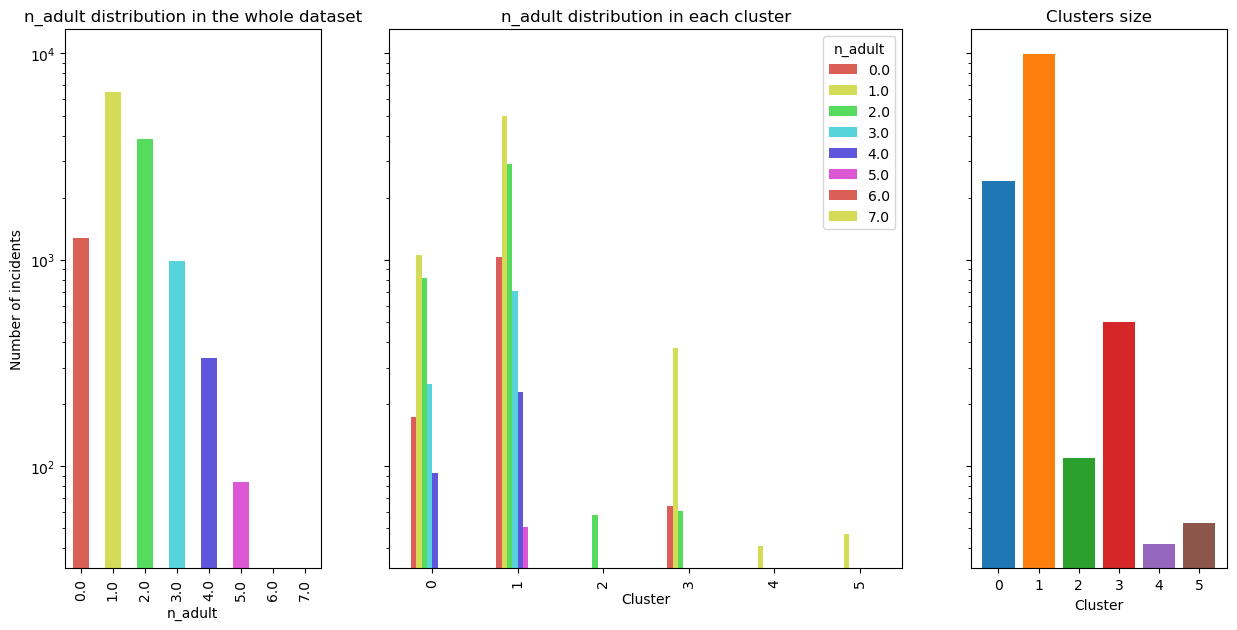

In [45]:
plot_bars_by_cluster(illinois_df[illinois_df['cluster']!=-1], feature='n_adult', 
    cluster_column='cluster', figsize=(10, 5), log_scale=True)

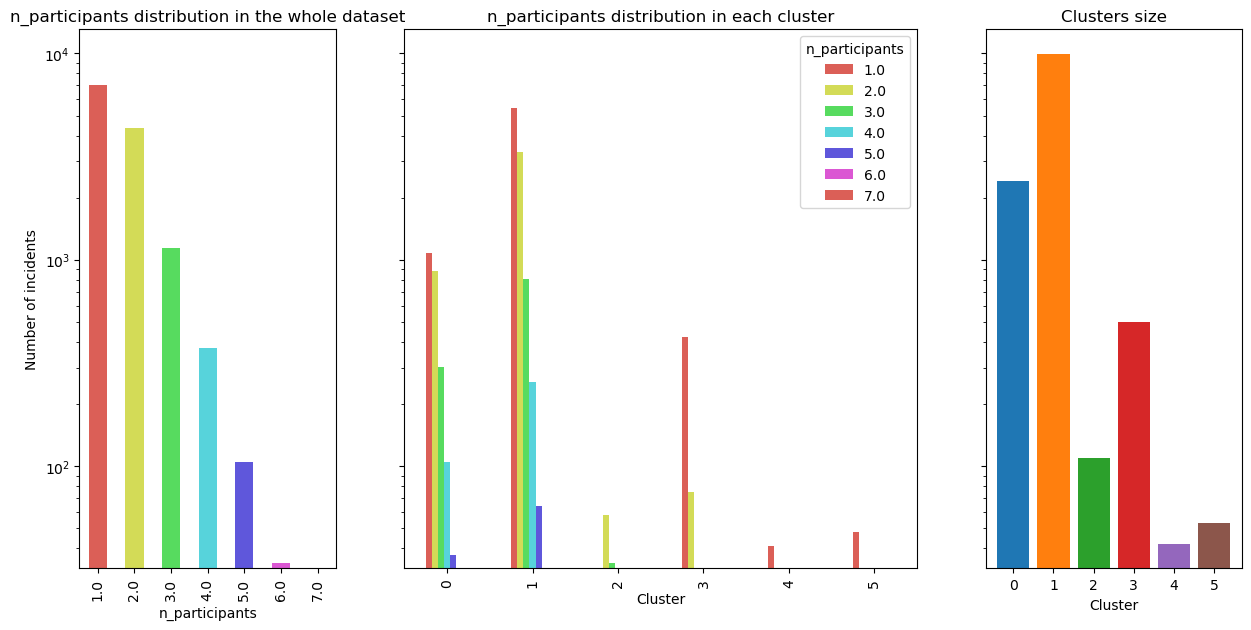

In [46]:
plot_bars_by_cluster(illinois_df[illinois_df['cluster']!=-1], feature='n_participants', 
    cluster_column='cluster', figsize=(10, 5), log_scale=True)

In the last 3 clusters (the least populated ones), there are no men or children, and they all belong to cluster 3. In cluster 3, there are few teenagers, and from the histograms, it can be observed that the majority of incidents clustered in clusters 3, 4, and 5 involve only one adult female participant.

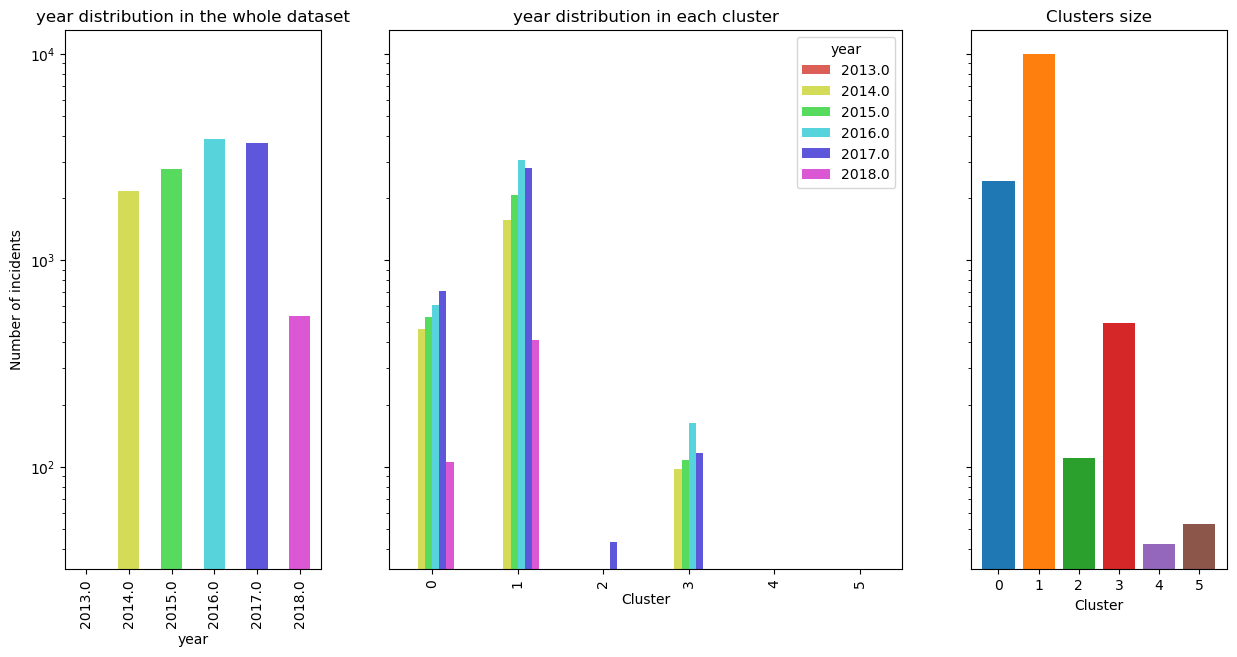

In [47]:
plot_bars_by_cluster(illinois_df[illinois_df['cluster']!=-1], feature='year', 
    cluster_column='cluster', figsize=(10, 5), log_scale=True)

We are unable to find significant patterns among the clusters concerning the temporal division into years.

## Noise Visualization

We present statistical metrics for all incidents in Illinois and specifically for those classified as noise by the DBSCAN algorithm. This analysis aims to provide insights into how the clustering algorithm identified noise points.

In [48]:
illinois_df.describe()[['min_age', 'max_age', 'avg_age', 'n_child', 'n_teen', 'n_adult', 'n_males',
       'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants']]

min_age       max_age       avg_age       n_child        n_teen  \
count  13234.000000  13234.000000  13234.000000  13231.000000  13231.000000   
mean      26.030905     28.075790     27.013072      0.008314      0.172474   
std        9.999261     11.013422     10.043248      0.107569      0.509354   
min        1.000000      1.000000      1.000000      0.000000      0.000000   
25%       19.000000     20.000000     20.000000      0.000000      0.000000   
50%       24.000000     25.000000     24.000000      0.000000      0.000000   
75%       30.000000     33.000000     31.000000      0.000000      0.000000   
max       87.000000     90.000000     87.000000      3.000000      6.000000   

            n_adult       n_males     n_females      n_killed     n_injured  \
count  13231.000000  13234.000000  13234.000000  13234.000000  13234.000000   
mean       1.492782      1.479900      0.146441      0.220417      0.866783   
std        1.008170      0.889121      0.410896      0.459338      0.733834   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      1.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      0.000000      0.000000      1.000000   
75%        2.000000      2.000000      0.000000      0.000000      1.000000   
max       17.000000     15.000000      5.000000      6.000000     12.000000   

         n_arrested    n_unharmed  n_participants  
count  13234.000000  13234.000000    13234.000000  
mean       0.205305      0.364289        1.673719  
std        0.527430      0.661628        0.945309  
min        0.000000      0.000000        1.000000  
25%        0.000000      0.000000        1.000000  
50%        0.000000      0.000000        1.000000  
75%        0.000000      1.000000        2.000000  
max        9.000000      8.000000       20.000000

In [49]:
illinois_df[illinois_df['cluster']==-1].describe()[['min_age', 'max_age', 'avg_age', 'n_child', 'n_teen', 'n_adult', 'n_males',
       'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants']]

min_age     max_age     avg_age     n_child      n_teen     n_adult  \
count  168.000000  168.000000  168.000000  168.000000  168.000000  168.000000   
mean    34.023810   45.892857   39.494048    0.065476    0.386905    3.505952   
std     21.452901   20.013180   19.752358    0.312224    1.104837    2.557125   
min      1.000000   15.000000   14.000000    0.000000    0.000000    0.000000   
25%     18.000000   29.000000   23.750000    0.000000    0.000000    2.000000   
50%     24.500000   43.000000   34.000000    0.000000    0.000000    3.000000   
75%     52.250000   59.250000   54.250000    0.000000    0.000000    5.000000   
max     87.000000   90.000000   87.000000    2.000000    6.000000   17.000000   

          n_males   n_females    n_killed   n_injured  n_arrested  n_unharmed  \
count  168.000000  168.000000  168.000000  168.000000  168.000000  168.000000   
mean     2.750000    1.059524    1.321429    1.113095    0.958333    0.535714   
std      2.558887    1.076156    1.164965    1.890492    1.594730    1.266297   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      2.000000    1.000000    1.000000    0.000000    0.000000    0.000000   
75%      4.000000    1.000000    2.000000    1.000000    1.000000    0.250000   
max     15.000000    5.000000    6.000000   12.000000    9.000000    8.000000   

       n_participants  
count      168.000000  
mean         3.958333  
std          2.688085  
min          1.000000  
25%          2.000000  
50%          3.000000  
75%          5.250000  
max         20.000000

In [50]:
print('Number of incidents classified as noise:', illinois_df[illinois_df['cluster']==-1].shape[0])
print('Number of noise incidents with at least one woman: ', 
    illinois_df[(illinois_df['cluster']==-1) & (illinois_df['females']==True)].shape[0])
print('Number of noise incidents where average age is over 27: ', 
    illinois_df[(illinois_df['cluster']==-1) & (illinois_df['avg_age']>27)].shape[0])
print('Number of noise incidents where there are more than two participants: ', 
    illinois_df[(illinois_df['cluster']==-1) & (illinois_df['n_participants']>2)].shape[0])

Number of incidents classified as noise: 168
Number of noise incidents with at least one woman:  113
Number of noise incidents where average age is over 27:  104
Number of noise incidents where there are more than two participants:  102


We can observe that in the majority of incidents classified as noise, there are women present, and the average age is higher than 27, which happens to be the average age of participants in incidents. Additionally, these incidents involve more than two participants, corresponding to the fourth quartile of the number of participants in incidents. 

These results suggest that such incidents could have been considered outliers in the dataset, indicating that the DBSCAN algorithm correctly identified these cases as noise.

## Compare DBSCAN with K-means

We also compare the clusters identified by the DBSCAN algorithm with those obtained from k-means clustering, setting k equal to the number of clusters identified by DBSCAN. This approach is suggested in the *'Cluster Evaluation'* chapter of *Pang-Ning Tan, Michael Steinbach, Vipin Kumar. Introduction to Data Mining.*

To obtain more information on the k-means algorithm, please refer to the notebook where the algorithm was thoroughly examined.

In [51]:
MAX_ITER = 300
N_INIT = 10
INIT_METHOD = 'k-means++'
MAX_K = 30
RANDOM_STATE = 42

def fit_kmeans(X, params):
    #print(f'Fitting KMeans with k={params['n_clusters']}')
    kmeans = KMeans(**params)
    kmeans.fit(X)
    results = {}
    results['model'] = kmeans
    results['SSE'] = kmeans.inertia_
    results['BSS'] = compute_bss_per_cluster(X=X, clusters=kmeans.labels_, centroids=kmeans.cluster_centers_, weighted=True).sum()
    results['davies_bouldin_score'] = davies_bouldin_score(X=X, labels=kmeans.labels_)
    results['calinski_harabasz_score'] = calinski_harabasz_score(X=X, labels=kmeans.labels_)
    results['silhouette_score'] = silhouette_score(X=X, labels=kmeans.labels_) 
    results['n_iter'] = kmeans.n_iter_
    return kmeans, results

In [53]:
results = {}
kmeans_params = {}
kmeans_params['random_state'] = RANDOM_STATE
kmeans_params['max_iter'] = MAX_ITER

kmeans_params['n_init'] = N_INIT
kmeans_params['n_clusters'] = 6
kmeans_params['init'] = INIT_METHOD

kmeans, results = fit_kmeans(X=X_minmax_illinois, params=kmeans_params)
results[str(k)+'means'] = results

In [54]:
results

{'model': KMeans(n_clusters=6, n_init=10, random_state=42),
 'SSE': 33950.82130916673,
 'BSS': 45451.87239045267,
 'davies_bouldin_score': 1.0723393571291953,
 'calinski_harabasz_score': 3541.9234833845135,
 'silhouette_score': 0.38137982510012003,
 'n_iter': 9,
 '20means': {...}}

To visualize the correspondence between clusters found by DBSCAN and k-means, we plotted the Sankey plot. It's important to note that in the Sankey plot for DBSCAN, Class 0 corresponds to the noise that we have referred to as -1. Additionally, all cluster labels are scaled by 1 for consistency.

In [55]:
sankey_plot(
    [kmeans.labels_, db.labels_],
    labels_titles=['Kmeans', 'DBSCAN'],
    title='Clusterings comparison'
)

From the plot, it is evident that clusters between 0 and 3 found by k-means are mapped into the most frequent cluster of DBSCAN. This suggests that we can map DBSCAN clusters to a k-means model with k=3 for a more concise representation.

In [56]:
kmeans_params['n_clusters'] = 3
kmeans = KMeans(**kmeans_params)
kmeans.fit(X_minmax_illinois)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [57]:
sankey_plot(
    [kmeans.labels_, db.labels_],
    labels_titles=['Kmeans', 'DBSCAN'],
    title='Clusterings comparison'
)

The results of this latest attempt have shown significant improvement. We can observe that K-means Cluster 1 has been entirely mapped to the clusters identified as 2 and 4 in the DBSCAN plot, K-means Cluster 2 to cluster 2, and K-means Cluster 0 to DBSCAN Cluster 1 and clusters 0, 3, and 6, representing noise and the less numerous classes in DBSCAN. We can, therefore, see clear correspondences in the cluster creation between the two algorithms.